## MobileUse

In [ ]:
import base64
from io import BytesIO
from openai import OpenAI
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
    NousFnCallPrompt,
    Message,
    ContentItem,
)
from qwen_vl_utils import smart_resize
import json
from PIL import Image
from utils.mobile_use import MobileUse
from utils.common import pil_to_base64, message_translate, parse_tags, extract_bboxes_from_brackets, draw_point, slim_messages
from IPython.display import display

def build_system_messages(resized_width, resized_height):
    

    mobile_use = MobileUse(
        cfg={"display_width_px": resized_width, "display_height_px": resized_height}
        # TODO
    )

    query_messages = [
        Message(
            role="system", content=[ContentItem(text="You are a helpful assistant.")]
        )
    ]

    messages = NousFnCallPrompt().preprocess_fncall_messages(
        messages=query_messages,
        functions=[mobile_use.function],
        lang=None,
    )
    messages = [m.model_dump() for m in messages]

    # messages[0]['content'][0]['type'] = 'text'
    # messages[0]['content'][1]['type'] = 'text'

    system_prompt_part = {'role': 'system', 'content': []} # TODO
    system_prompt_part['content'].append(
        {'text': messages[0]['content'][0]['text'] + messages[0]['content'][1]['text']})

    
    
    return system_prompt_part

def build_user_messages(instruction, enable_think=False, history=None, think_tag_begin='<thinking>', think_tag_end='</thinking>'):
    if history is None:
        history = []
    user_prompt = f'''The user query: {instruction}'''
    history = ''.join([f'Step {si+1}: {_}; 'for si, _ in enumerate(history)])
    user_prompt += f'\nTask progress (You have done the following operation on the current device): {history}.\n'
    if enable_think:
        user_prompt += f'\nBefore answering, explain your reasoning step-by-step in {think_tag_begin}{think_tag_end} tags, and insert them before the <tool_call></tool_call> XML tags.'
        user_prompt += '\nAfter answering, summarize your action in <conclusion></conclusion> tags, and insert them after the <tool_call></tool_call> XML tags.'
    user_messages = {"role": "user", "content": [{"text": user_prompt + '\n'}]}
    return user_messages

screenshot = "../assets/screenshot/mobile_example.jpg"
dummy_image = Image.open(screenshot)


MIN_PIXELS=3136
MAX_PIXELS=10035200
resized_height, resized_width  = smart_resize(dummy_image.height,
    dummy_image.width,
    factor=28,
    min_pixels=MIN_PIXELS,
    max_pixels=MAX_PIXELS,)
dummy_image = dummy_image.resize((resized_width, resized_height))

system_messages = build_system_messages(dummy_image.width, dummy_image.height)
user_messages = build_user_messages("View a review of '三文鱼' in '大众点评'", enable_think=True, history=["Open '大众点评' App", "Swipe up to scroll down"])

## private image url usage
# from x.io.oss_info import OssMan
# osm = OssMan()
# user_messages['content'].append({"image": osm.make_tmp_image_url(dummy_image)})

## public image usage
user_messages['content'].append({"image": f"data:image/png;base64,{pil_to_base64(dummy_image)}"})

messages = [system_messages, user_messages]

messages_oai = message_translate(messages, to_format='openai')
print(json.dumps(messages_oai, indent=2, ensure_ascii=False))

## Deploy your own vllm openai server
bot = OpenAI(
            api_key='fill it',
            base_url='fill it',
            timeout=30
        )
model_name = 'fill it'

chat_completion_from_url = bot.chat.completions.create(
    model=model_name, 
    messages=messages_oai, **{})
result = chat_completion_from_url.choices[0].message.content

action_content = json.loads(parse_tags(result, ['tool_call'])['tool_call'])['arguments']

print(action_content)
if 'coordinate' in action_content:
    dummy_image = draw_point(dummy_image, action_content['coordinate'])
dummy_image

#### Multi Round Multi Image Evaluation (for Android Control)

In [ ]:

def build_user_messages_next_round(enable_think=False, think_tag_begin='<thinking>', think_tag_end='</thinking>'):
  
    user_prompt = f''''''
    if enable_think:
        user_prompt += f'\nBefore answering, explain your reasoning step-by-step in {think_tag_begin}{think_tag_end} tags, and insert them before the <tool_call></tool_call> XML tags.'
        user_prompt += '\nAfter answering, summarize your action in <conclusion></conclusion> tags, and insert them after the <tool_call></tool_call> XML tags.'
    user_messages = {"role": "user", "content": [{"text": user_prompt + '\n'}]}
    return user_messages

messages.append({"role": "assistant", "content": [{"text": result}]})
messages.append(build_user_messages_next_round())
messages[-1]['content'].append({"image": f"data:image/png;base64,{pil_to_base64(dummy_image)}"}) # add screenshot of next round
messages = slim_messages(messages, num_image_limit=2)

messages_oai = message_translate(messages, to_format='openai')
print(json.dumps(messages_oai, indent=2, ensure_ascii=False))

## Computer Use

[
  {
    "role": "system",
    "content": [
      {
        "type": "text",
        "text": "You are a helpful assistant."
      },
      {
        "type": "text",
        "text": "\n\n# Tools\n\nYou may call one or more functions to assist with the user query.\n\nYou are provided with function signatures within <tools></tools> XML tags:\n<tools>\n{\"type\": \"function\", \"function\": {\"name\": \"computer_use\", \"description\": \"Use a mouse and keyboard to interact with a computer, and take screenshots.\\n* This is an interface to a desktop GUI. You do not have access to a terminal or applications menu. You must click on desktop icons to start applications.\\n* Some applications may take time to start or process actions, so you may need to wait and take successive screenshots to see the results of your actions. E.g. if you click on Firefox and a window doesn't open, try wait and taking another screenshot.\\n* The screen's resolution is 1288x728.\\n* Whenever you intend to move the

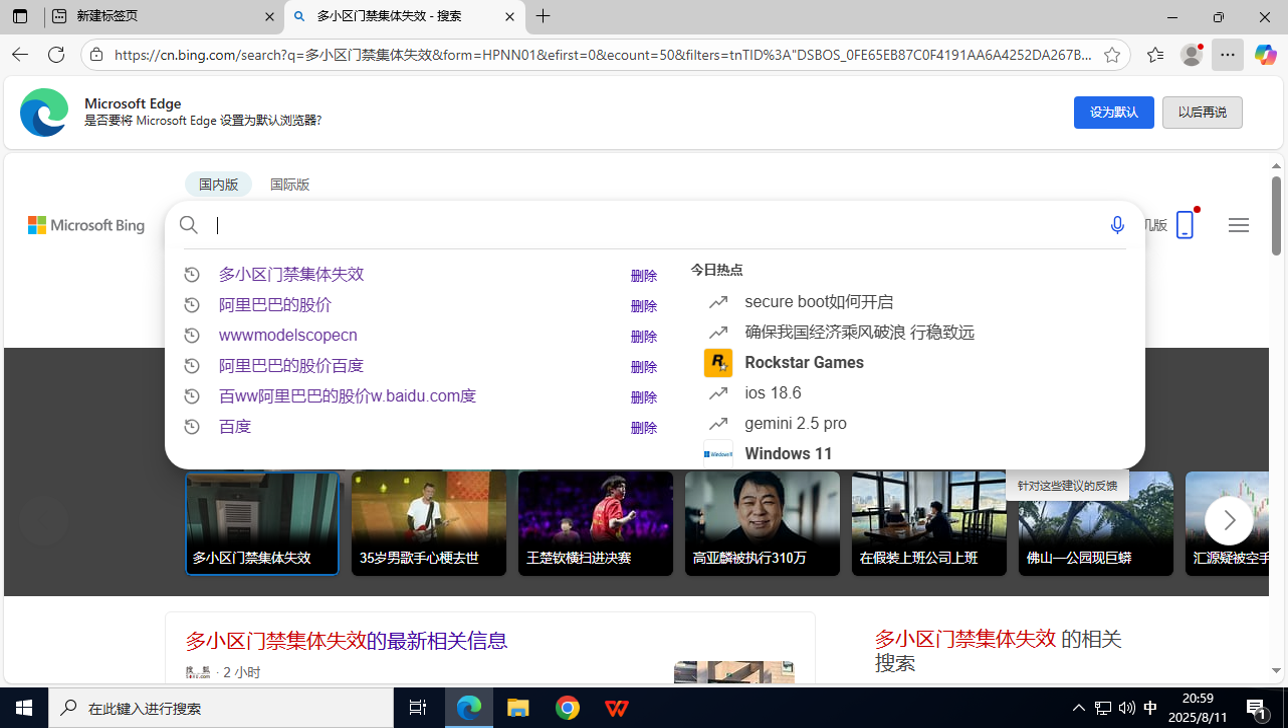

In [ ]:
import json
from io import BytesIO
from PIL import Image

from openai import OpenAI
from qwen_agent.llm.fncall_prompts.nous_fncall_prompt import (
NousFnCallPrompt,
Message,
ContentItem,
)
from qwen_vl_utils import smart_resize

from utils.common import (
pil_to_base64,
message_translate,
parse_tags,
draw_point,
)

from utils.computer_use import ComputerUse


def build_system_messages_pc(resized_width: int, resized_height: int):
    computer_use = ComputerUse(
    cfg={"display_width_px": resized_width, "display_height_px": resized_height}
    )

    query_messages = [
        Message(role="system", content=[ContentItem(text="You are a helpful assistant.")])
    ]

    messages = NousFnCallPrompt().preprocess_fncall_messages(
        messages=query_messages,
        functions=[computer_use.function],
        lang=None,
    )
    messages = [m.model_dump() for m in messages]

    system_prompt_part = {"role": "system", "content": []}
    for c in messages[0]["content"]:
        system_prompt_part["content"].append({"text": c["text"]})
    return system_prompt_part

def build_user_messages_pc(instruction: str, history=None, enable_think=True):

    if history is None:
        history = []
    if len(history) == 0:
        history_str = "No history. This is the first step."
    else:
        history_str = ""
    for i, h in enumerate(history):
        history_str += f"Step {i+1}: {h}\n"

    user_prompt = (
        "Please generate the next move according to the UI screenshot, instruction and previous actions.\n"
        f"Instruction: {instruction}\n"
        "Previous actions:\n"
        f"{history_str}\n"
    )
    if enable_think:
        user_prompt += (
            "Before answering, explain your reasoning step-by-step in <thinking></thinking> tags, "
            "and insert them before the <tool_call></tool_call> XML tags.\n"
            "After answering, summarize your action in <conclusion></conclusion> tags, "
            "and insert them after the <tool_call></tool_call> XML tags."
        )

    user_messages = {"role": "user", "content": [{"text": user_prompt + "\n"}]}
    return user_messages


screenshot = "../assets/screenshot/windows_example.png" # 替换成你的桌面截图路径
dummy_image = Image.open(screenshot)

MIN_PIXELS = 100 * 28 * 28
MAX_PIXELS = 12800 * 28 * 28 # if you pass images more than 3, set MAX_PIXELS to 3211264
resized_h, resized_w = smart_resize(
dummy_image.height, dummy_image.width, factor=28, min_pixels=MIN_PIXELS, max_pixels=MAX_PIXELS
)
dummy_image = dummy_image.resize((resized_w, resized_h))

system_messages = build_system_messages_pc(resized_w, resized_h)
user_messages = build_user_messages_pc(
    "Open the browser and search for 'mPLUG-Owl3'.",
    history=["Open the Start menu", "Click the Edge Browser icon"],
    enable_think=True,
)



user_messages['content'].append({"image": f"data:image/png;base64,{pil_to_base64(dummy_image)}"})

messages = [system_messages, user_messages]

messages_oai = message_translate(messages, to_format="openai")
print(json.dumps(messages_oai, indent=2, ensure_ascii=False))

bot = OpenAI(
            api_key='fill it',
            base_url='fill it',
            timeout=30
        )
model_name = 'fill it'

chat_completion = bot.chat.completions.create(model=model_name, messages=messages_oai)
print(chat_completion)
result_text = chat_completion.choices[0].message.content
print("\n==== Raw model output ====\n", result_text)

tags = parse_tags(result_text, ["tool_call"])

tool_call_json_str = tags["tool_call"]
tool_call = json.loads(tool_call_json_str)
action_args = tool_call.get("arguments", {})
print("\n==== Parsed tool_call arguments ====\n", json.dumps(action_args, indent=2, ensure_ascii=False))


if "coordinate" in action_args and isinstance(action_args["coordinate"], list):
    img_vis = draw_point(img_resized.copy(), action_args["coordinate"])
    display(img_vis)
else:
    display(img_resized)